# NOTEBOOK to Detect Text in Images

## Introduction

Text detection techniques required to detect the text in the image and create and bounding box around the portion of the image having text. 

EAST (Efficient accurate scene text detector)
This is a very robust deep learning method for text detection based on this [paper](https://arxiv.org/abs/1704.03155v2). It can find horizontal and rotated bounding boxes. It can be used in combination with any text recognition method.

### Library Imports
In this session, all external libraries are imported.

In [1]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import os
import math
import shutil
from operator import itemgetter
from scipy import stats

In [2]:
def east(image):
    
    '''
     Function to load the text detection model and identify the texts.
    
     params:
         image: Image where the texts will be located.
        
     return:
         boxes: Array of bounding boxes of the identified words
         rW: proportion of the bounding box found with the original image
         rH: proportion of the bounding box found with the original image
    '''
    
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    (newW, newH) = 320, 320
    rW = W / float(newW)
    rH = H / float(newH)
    
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    
    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    net = cv2.dnn.readNet("model/frozen_east_text_detection.pb")
    
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    
    rects = []
    confidences = []
    
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.3:
                continue
                
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences, overlapThresh=0.5)
    
    return boxes, rW, rH

In [6]:
def get_bb(image, boxes, rW, rH):

    '''
    Function to correct the proportion of bounding boxes, create a new bounding box 
    involving all part of the image that has text
    
    params:
        image: Image where the texts were located.
        boxes: Array of bounding boxes of identified words
        rW: proportion of the bounding box found with the original image
        rH: proportion of the bounding box found with the original image
        
    return:
        image: Image with the bounding box drawn
        box: list with bounding boxes adjusted to the aspect ratio
    '''
    
    box = []
    
    for (startX, startY, endX, endY) in boxes:
        
        x_1 = int(startX * rW)
        y_1 = int(startY * rH)
        x_2 = int(endX * rW)
        y_2 = int(endY * rH)
        
        box.append((x_1, y_1, x_2, y_2))     
                   
#         print(x_1, y_1, x_2, y_2)
        image = cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (0,255,0), 2)

                   
    return image, box

In [11]:
def text_detection(img):
    """
    Function to detect text in image
    """
    
    image_2 = img.copy()
    
    # Using EAST to detect text in the image
    boxes, rW, rH = east(image_2)
    
    # Adjusting the proportion of bounding boxes and drawing
    image_2, box = get_bb(image_2, boxes, rW, rH)
    
    # Plotting result
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    print(boxes)

[[ 86  79 238 128]]


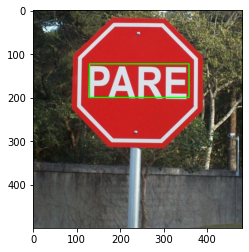

In [15]:
file = "images/image_2.jpg"
image = cv2.imread(file)

text_detection(image)

[[ 37 120 265 176]]


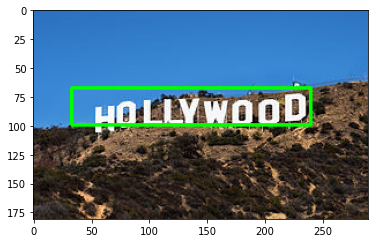

In [16]:
file = "images/image_1.jpg"
image = cv2.imread(file)

text_detection(image)